In [ ]:
!pip install nltk --quiet

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('vader_lexicon')
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
review_df = pd.read_csv("/content/FINAL_TypeA_cleaned_reviews.csv")
price_df = pd.read_csv("/content/Type A Sales.csv")

In [ ]:
price_df.head(5)

,Date,Best Seller Rank,Price
0,4/22/2024,762,$7.88
1,4/23/2024,769,$7.88
2,4/24/2024,823,$7.88
3,4/25/2024,816,$7.88
4,4/26/2024,925,$7.88


In [ ]:
review_df.head(5)

,profileName,text,helpful,Rating,ReviewDate,Sentiment,SentimentScore,HelpfulNormalized,WeightedSentiment,cleaned_tokens
0,Diogo Santos Valada,THE WORST PRODUCT EVER!!! I used it for 3 days...,2,1.0,2021-03-29,negative,1,0.019417,1.019417,worst product ever used day applied day face g...
1,A MOM,I have oily skin but it didn’t suit me.. did n...,0,1.0,2021-06-13,negative,1,0.000000,1.000000,oilyskin ’ suit like
2,Toni,I have combo skin! This makes my face look oil...,0,3.0,2021-09-11,neutral,1,0.000000,1.000000,combo skin make face look oily initially put c...
3,SPionage,I bought this sunscreen with the intention of ...,0,2.0,2021-11-19,negative,1,0.000000,1.000000,bought sunscreen intention wearing everyday pa...
4,Destiny shepherd,I like that it don’t feel sticky or anything b...,3,2.0,2022-01-16,negative,1,0.029126,1.029126,like ’ feel sticky anything ’ good product bla...


In [ ]:
# prompt: drop from review_df columns variant:style,images, and rename ReviewText to text and ReviewDate to date

review_df = review_df.drop(columns=['profileName'])
review_df = review_df.rename(columns={ 'ReviewDate': 'Date'})


In [ ]:
review_df['Date'] = pd.to_datetime(review_df['Date'])
price_df['Date'] = pd.to_datetime(price_df['Date'])

In [ ]:
price_df['Price'] = price_df['Price'].replace('[\$,]', '', regex=True).astype(float)

In [ ]:
price_df.head(5)

,Date,Best Seller Rank,Price
0,2024-04-22,762,7.88
1,2024-04-23,769,7.88
2,2024-04-24,823,7.88
3,2024-04-25,816,7.88
4,2024-04-26,925,7.88


In [ ]:
review_df.head(5)

,text,helpful,Rating,Date,Sentiment,SentimentScore,HelpfulNormalized,WeightedSentiment,cleaned_tokens
0,THE WORST PRODUCT EVER!!! I used it for 3 days...,2,1.0,2021-03-29,negative,1,0.019417,1.019417,worst product ever used day applied day face g...
1,I have oily skin but it didn’t suit me.. did n...,0,1.0,2021-06-13,negative,1,0.000000,1.000000,oilyskin ’ suit like
2,I have combo skin! This makes my face look oil...,0,3.0,2021-09-11,neutral,1,0.000000,1.000000,combo skin make face look oily initially put c...
3,I bought this sunscreen with the intention of ...,0,2.0,2021-11-19,negative,1,0.000000,1.000000,bought sunscreen intention wearing everyday pa...
4,I like that it don’t feel sticky or anything b...,3,2.0,2022-01-16,negative,1,0.029126,1.029126,like ’ feel sticky anything ’ good product bla...


## Feature Engineering

We will calculate real sentiment scores from the text column (reviews) using VADER sentiment analyzer.

VADER is perfect for short product reviews

It gives a sentiment score between -1 (very negative) to +1 (very positive)

In [ ]:
sia = SentimentIntensityAnalyzer()

# Calculate sentiment score for each review
review_df['sentiment_score'] = review_df['text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

In [ ]:
review_df.head(3)

,text,helpful,Rating,Date,Sentiment,SentimentScore,HelpfulNormalized,WeightedSentiment,cleaned_tokens,sentiment_score
0,THE WORST PRODUCT EVER!!! I used it for 3 days...,2,1.0,2021-03-29,negative,1,0.019417,1.019417,worst product ever used day applied day face g...,-0.7270
1,I have oily skin but it didn’t suit me.. did n...,0,1.0,2021-06-13,negative,1,0.000000,1.000000,oilyskin ’ suit like,-0.3950
2,I have combo skin! This makes my face look oil...,0,3.0,2021-09-11,neutral,1,0.000000,1.000000,combo skin make face look oily initially put c...,0.8346


In [ ]:
# Aggregate Review Data Daily
daily_reviews = review_df.groupby('Date').agg(
    review_count=('text', 'count'),
    avg_rating=('Rating', 'mean'),
    avg_sentiment=('sentiment_score', 'mean')  # Now using true sentiment!
).reset_index().rename(columns={'date': 'Date'})

In [ ]:
daily_reviews.head(3)

,Date,review_count,avg_rating,avg_sentiment
0,2021-03-29,1,1.0,-0.7270
1,2021-06-13,1,1.0,-0.3950
2,2021-09-11,1,3.0,0.8346


In [ ]:
#Merge datasets
merged_df = pd.merge(price_df, daily_reviews, on='Date', how='left')
# Step 9: Fill missing values
merged_df['review_count'] = merged_df['review_count'].fillna(0)
merged_df['avg_rating'] = merged_df['avg_rating'].fillna(0)
merged_df['avg_sentiment'] = merged_df['avg_sentiment'].fillna(0)

# Clean "Best Seller Rank" by removing commas and converting to int
merged_df['Best Seller Rank'] = merged_df['Best Seller Rank'].replace(',', '', regex=True).astype(float)

# Calculate proxy_sales
merged_df['proxy_sales'] = (merged_df['review_count'] * merged_df['avg_sentiment']) / merged_df['Price']

merged_df.head(5)

,Date,Best Seller Rank,Price,review_count,avg_rating,avg_sentiment,proxy_sales
0,2024-04-22,762.0,7.88,0.0,0.0,0.000000,0.000000
1,2024-04-23,769.0,7.88,1.0,4.0,-0.750600,-0.095254
2,2024-04-24,823.0,7.88,0.0,0.0,0.000000,0.000000
3,2024-04-25,816.0,7.88,0.0,0.0,0.000000,0.000000
4,2024-04-26,925.0,7.88,3.0,2.0,-0.057667,-0.021954


In [ ]:
merged_df.describe()

,Date,Best Seller Rank,Price,review_count,avg_rating,avg_sentiment,proxy_sales
count,365,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2024-10-21 02:18:04.931506944,1328.589041,10.105315,0.665753,1.708219,0.127048,0.020622
min,2024-04-22 00:00:00,-1.000000,2.090000,0.000000,0.000000,-0.988400,-0.162679
25%,2024-07-22 00:00:00,530.000000,9.180000,0.000000,0.000000,0.000000,0.000000
50%,2024-10-21 00:00:00,985.000000,10.840000,0.000000,0.000000,0.000000,0.000000
75%,2025-01-20 00:00:00,2093.000000,11.140000,1.000000,4.000000,0.348900,0.039508
max,2025-04-22 00:00:00,3416.000000,12.180000,4.000000,5.000000,0.994400,0.705933
std,NaN,855.313268,1.983494,0.866377,2.050814,0.349962,0.066015


## EDA on Final Dataset

In [ ]:
# 1. 📈 Proxy Sales Over Time
fig1 = px.line(merged_df, x='Date', y='proxy_sales', title='📈 Proxy Sales Over Time',
               labels={'proxy_sales': 'Proxy Sales', 'Date': 'Date'})
fig1.show()

This visualization shows the daily proxy sales trend for Neutrogena's Ultra Sheer sunscreen from May 2024 to April 2025. The proxy sales values fluctuate frequently, with several noticeable spikes (e.g., in July, September, and March) likely tied to marketing pushes, seasonal demand, or positive review bursts. However, there are also dips and volatility throughout, suggesting inconsistent customer engagement or external disruptions. Overall, while there’s no clear upward trend, the product has maintained moderate attention across the year.

In [ ]:
# 2. 🏆 Best Seller Rank Over Time (lower is better)
fig2 = px.line(merged_df, x='Date', y='Best Seller Rank',
               title='🏆 Best Seller Rank Over Time (lower = better)',
               labels={'Best Seller Rank': 'Amazon Rank', 'Date': 'Date'})
fig2.update_yaxes(autorange="reversed")
fig2.show()

This chart tracks the **Best Seller Rank (BSR)** of the Neutrogena sunscreen over time, where **lower ranks indicate better performance**. The product maintained a relatively strong rank (~#400–600) from May to August 2024, followed by a **sharp drop in rank (worse performance)** in the fall. There were a few **spikes back into higher ranks** (i.e., better sales) around **November 2024 and February 2025**, but overall, the trend suggests **increasing volatility** and a **gradual decline in best-seller performance** heading into 2025.

<ipython-input-20-9e4489c213bf>:6: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.



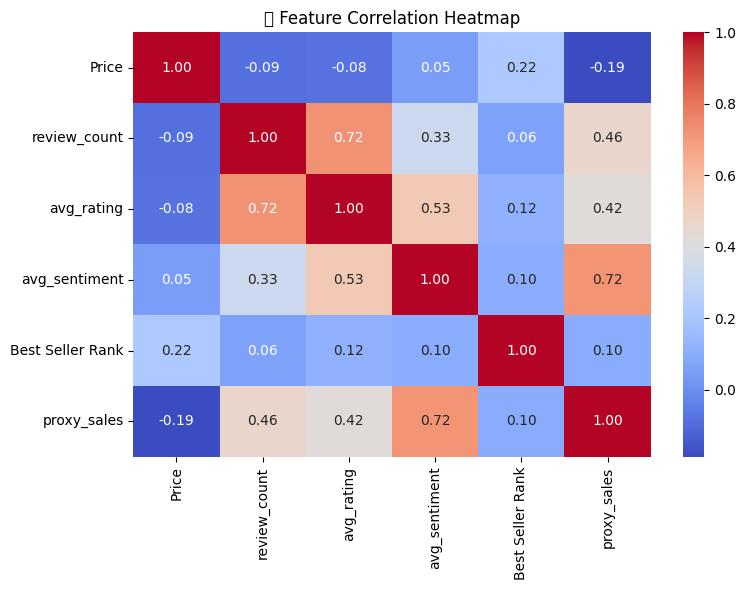

In [ ]:
# 3. 🔗 Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(merged_df[['Price', 'review_count', 'avg_rating', 'avg_sentiment', 'Best Seller Rank', 'proxy_sales']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔗 Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

## Model Trainning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
features = ['Price', 'review_count', 'avg_rating', 'avg_sentiment', 'Best Seller Rank']
X = merged_df[features]
y = merged_df['proxy_sales']

📊 Model Performance:
MAE:  0.0157
RMSE: 0.0259
R²:   0.5982

📌 Feature Importance:
avg_sentiment       0.141807
review_count        0.035645
Best Seller Rank    0.000006
Price              -0.008155
avg_rating         -0.010864
dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.



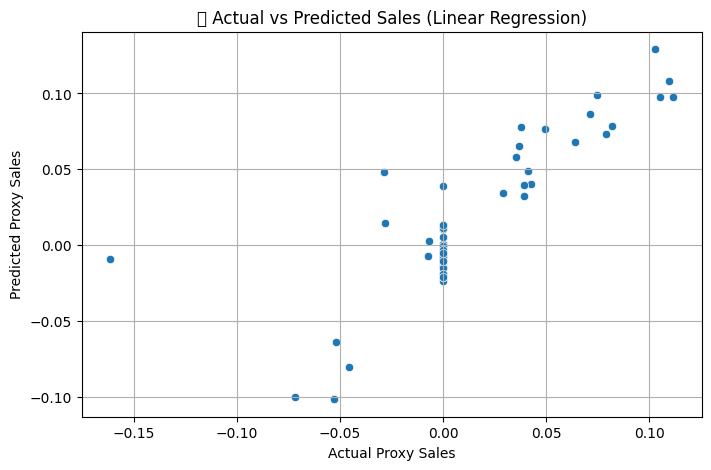

In [ ]:
# Step 5: Train-test split (time-independent)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Initialize and train model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 7: Make predictions
y_pred = model.predict(X_test)

# Step 8: Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📊 Model Performance:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# Step 9: Feature importance
coefficients = pd.Series(model.coef_, index=features)
print("\n📌 Feature Importance:")
print(coefficients.sort_values(ascending=False))

# Optional: Visualize actual vs predicted
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Proxy Sales")
plt.ylabel("Predicted Proxy Sales")
plt.title("🎯 Actual vs Predicted Sales (Linear Regression)")
plt.grid(True)
plt.show()

               Model       MAE      RMSE        R²
1      Random Forest  0.003170  0.009769  0.942875
2            XGBoost  0.003655  0.012639  0.904381
3   Ridge Regression  0.015341  0.025738  0.603460
0  Linear Regression  0.015689  0.025908  0.598207


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.



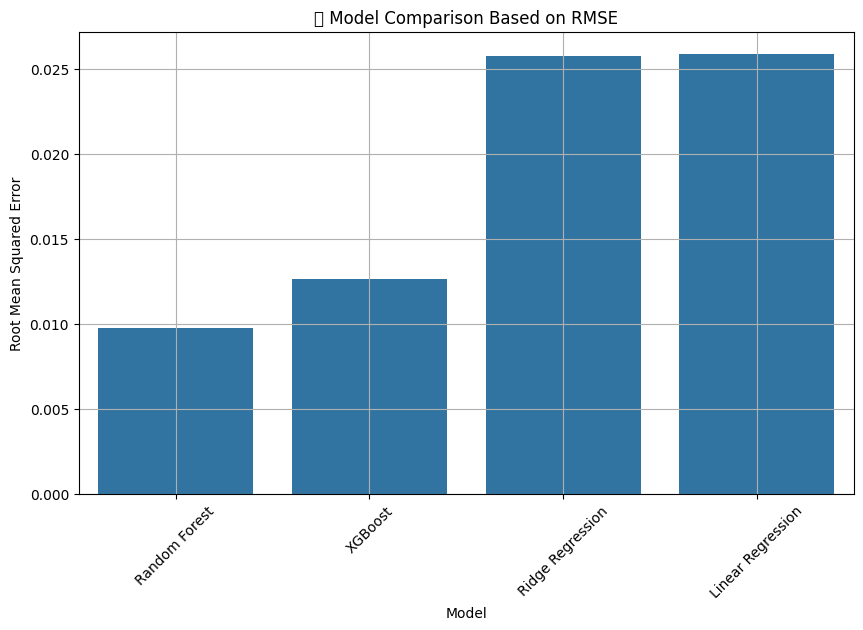

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0)
}

# Step 5: Train, predict, and evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

# Step 6: Create results table
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print(results_df)

# Step 7: Plot model performance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('🚀 Model Comparison Based on RMSE')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

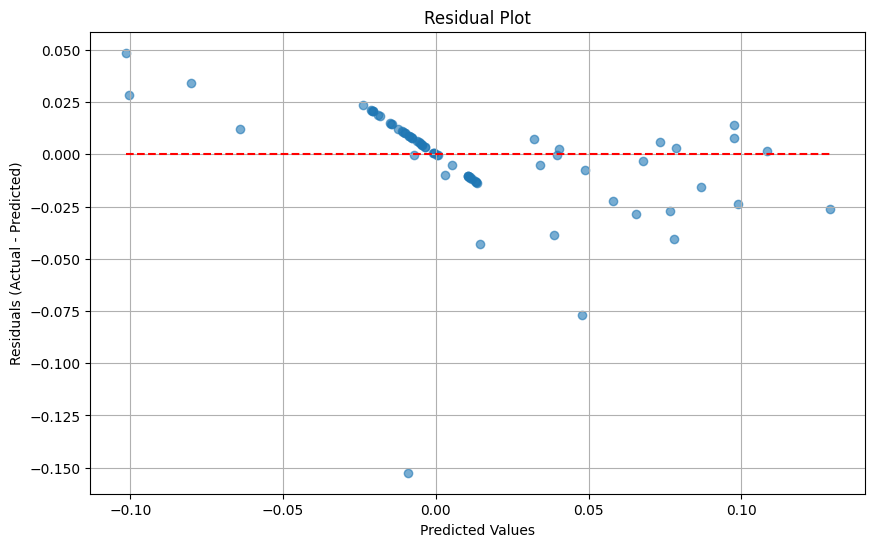

In [ ]:
import matplotlib.pyplot as plt
models = {
    "Linear Regression": LinearRegression(),
    #"Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    #"XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    #"Ridge Regression": Ridge(alpha=1.0)
}

# Step 5: Train, predict, and evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

# Assuming you already have predictions
y_pred = model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='dashed')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

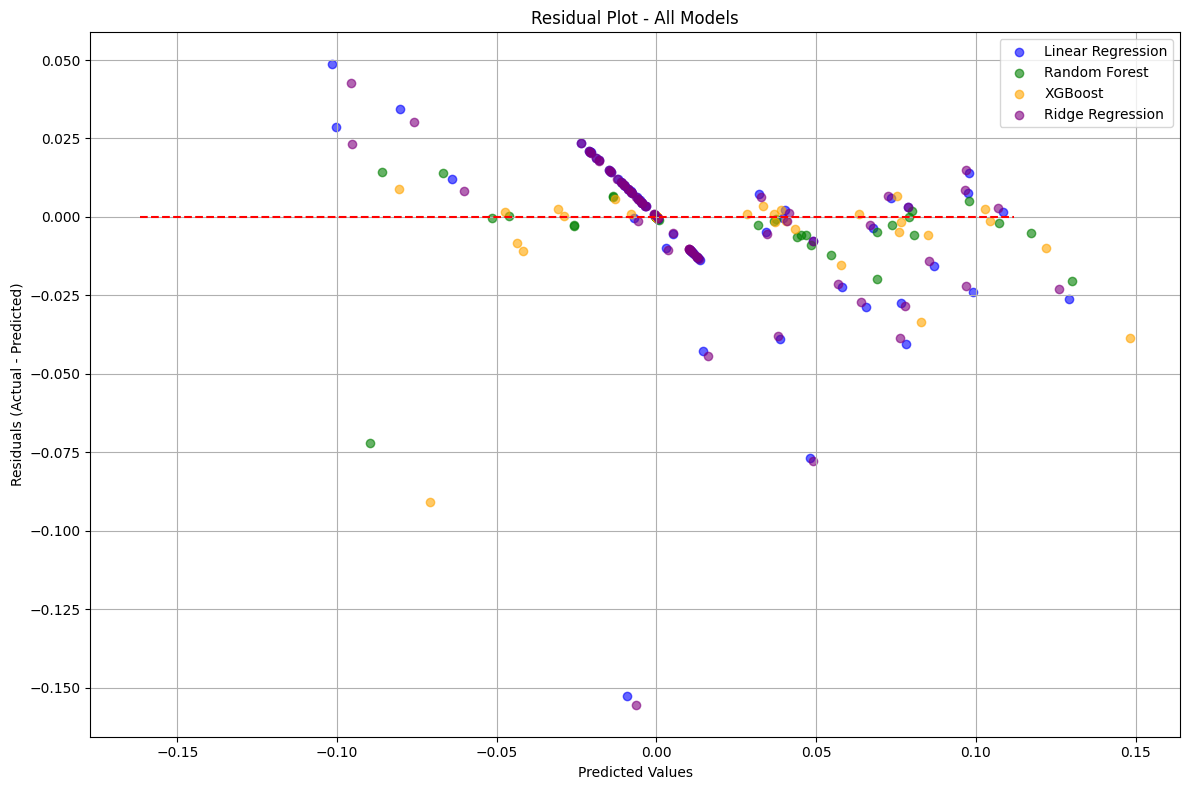

               Model       MAE      RMSE        R²
1      Random Forest  0.003170  0.009769  0.942875
2            XGBoost  0.003655  0.012639  0.904381
3   Ridge Regression  0.015341  0.025738  0.603460
0  Linear Regression  0.015689  0.025908  0.598207


In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0)
}

# Colors for different models
colors = ['blue', 'green', 'orange', 'purple']

# Set up plot
plt.figure(figsize=(12,8))

# Step 5: Train, predict, evaluate, and plot residuals
results = []
for (name, model), color in zip(models.items(), colors):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

    # Calculate residuals
    residuals = y_test - y_pred

    # Scatter plot for each model
    plt.scatter(y_pred, residuals, alpha=0.6, label=name, color=color)

# Add horizontal line at zero
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='red', linestyles='dashed')

# Decorations
plt.title('Residual Plot - All Models')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Results Table
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print(results_df)

           Model      MAE      RMSE        R²
0  Random Forest  0.00317  0.009769  0.942875


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.



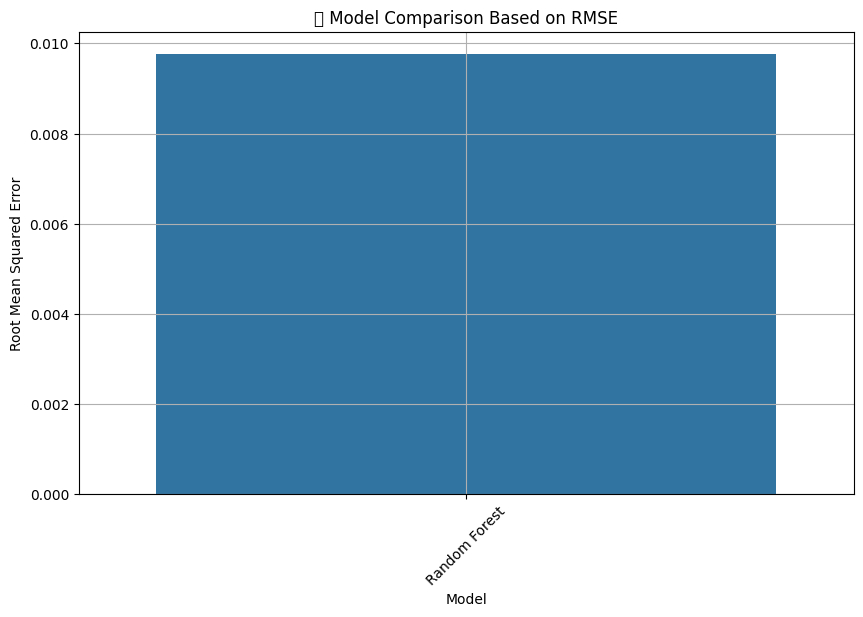

In [ ]:
models = {"Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)}

# Step 5: Train, predict, and evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })
    # Save the model if it's XGBoost
    if name == "Random Forest":
        model_xgb = model  # <----- THIS LINE
# Step 6: Create results table
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print(results_df)

# Step 7: Plot model performance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('🚀 Model Comparison Based on RMSE')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Forecasting Models

In [ ]:
!pip install prophet --quiet

In [ ]:
from prophet import Prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ded6vrq/ayjtfiih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ded6vrq/q560kqwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79400', 'data', 'file=/tmp/tmp0ded6vrq/ayjtfiih.json', 'init=/tmp/tmp0ded6vrq/q560kqwx.json', 'output', 'file=/tmp/tmp0ded6vrq/prophet_model5p51t16v/prophet_model-20250427064459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:44:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:44:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing fr

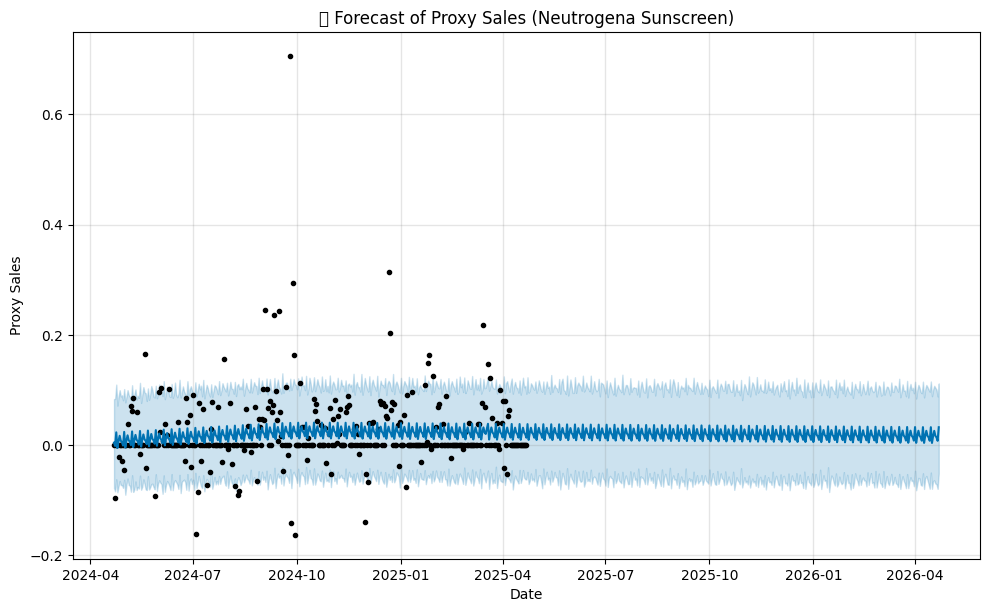

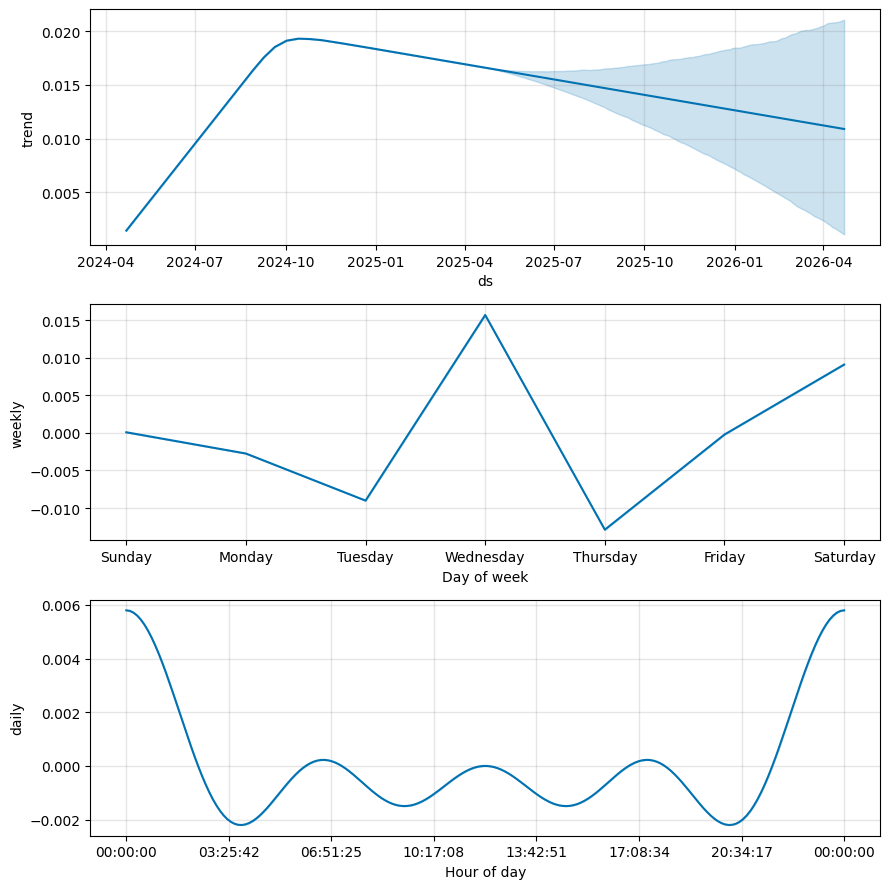

In [ ]:
prophet_df = merged_df[['Date', 'proxy_sales']].copy()
prophet_df = prophet_df.rename(columns={'Date': 'ds', 'proxy_sales': 'y'})

# Step 4: Initialize and Train Prophet Model
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

# Step 5: Create Future DataFrame
future = model.make_future_dataframe(periods=365, freq='D')  # Forecast for next 365 days (2025–2026)

# Step 6: Make Forecast
forecast = model.predict(future)

# Step 7: Visualize the forecast
fig1 = model.plot(forecast)
plt.title("📈 Forecast of Proxy Sales (Neutrogena Sunscreen)")
plt.xlabel("Date")
plt.ylabel("Proxy Sales")
plt.show()

# Step 8: Optional - Show forecast components (trend, weekly seasonality)
fig2 = model.plot_components(forecast)
plt.show()

Let’s now evaluate how well Prophet performs on your actual historical data 📊
We'll split your data into training + test, forecast into the test period

#BLOCK A — Forecast with Random Variation

<ipython-input-54-244440029bd8>:36: UserWarning:

Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.



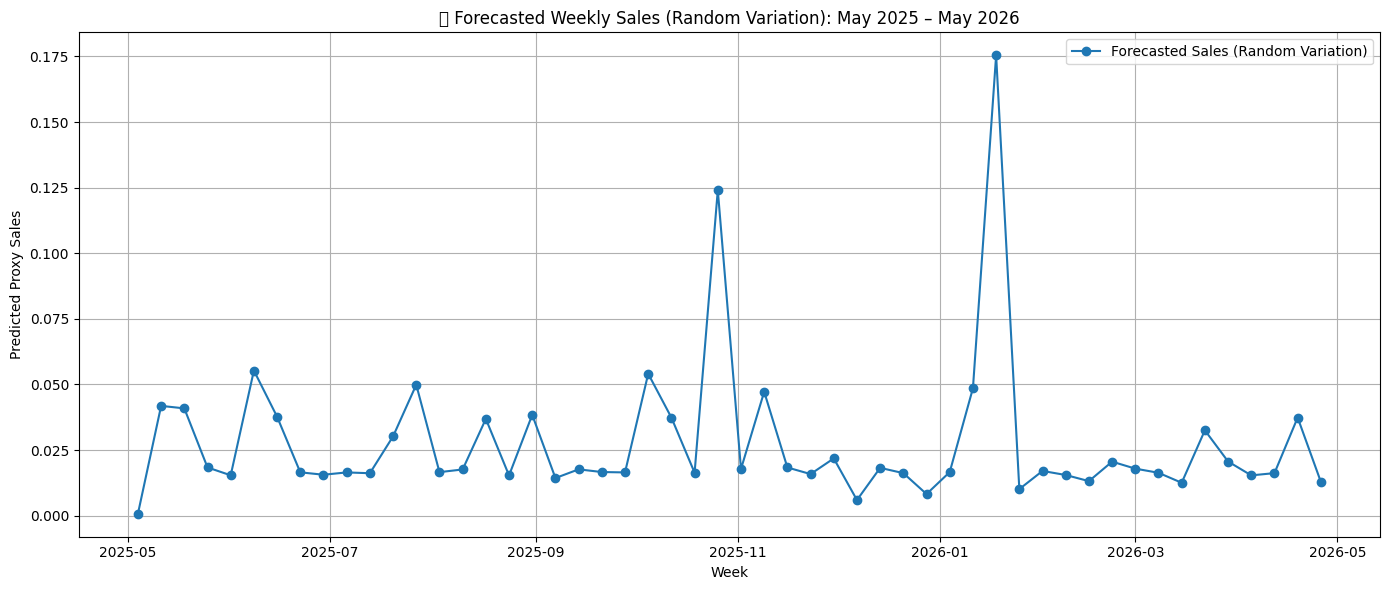

In [ ]:
# 1. Create weekly future date range
future_weeks = pd.date_range(start='2025-05-01', end='2026-05-01', freq='W')
weeks = len(future_weeks)

# 2. Calculate historical averages from daily data
avg_price = merged_df['Price'].mean()
avg_sentiment = merged_df['avg_sentiment'].mean()
avg_rating = merged_df['avg_rating'].mean()
avg_reviews = merged_df['review_count'].mean()
avg_bsr = merged_df['Best Seller Rank'].mean()

# 3. Build future feature table with random noise
df_future_random = pd.DataFrame({
    'Date': future_weeks,
    'Price': avg_price + np.random.normal(0, 0.5, size=weeks),
    'review_count': avg_reviews + np.random.normal(0, 3, size=weeks),
    'avg_rating': avg_rating + np.random.normal(0, 0.1, size=weeks),
    'avg_sentiment': avg_sentiment + np.random.normal(0, 0.05, size=weeks),
    'Best Seller Rank': avg_bsr + np.random.normal(0, 100, size=weeks)
})

# 4. Predict
X_random = df_future_random[['Price', 'review_count', 'avg_rating', 'avg_sentiment', 'Best Seller Rank']]
# Rename the 'Date' column to 'ds' for Prophet compatibility
X_random = X_random.rename(columns={'Date': 'ds'})  # Rename column
df_future_random['PredictedSales'] = model_xgb.predict(X_random[['Price', 'review_count', 'avg_rating', 'avg_sentiment', 'Best Seller Rank']]) # Use xgb model instead of prophet

# 5. Plot
plt.figure(figsize=(14,6))
plt.plot(df_future_random['Date'], df_future_random['PredictedSales'], marker='o', label='Forecasted Sales (Random Variation)')
plt.title('📦 Forecasted Weekly Sales (Random Variation): May 2025 – May 2026')
plt.xlabel('Week')
plt.ylabel('Predicted Proxy Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#BLOCK B — Forecast with Seasonality + Trend

<ipython-input-57-2bd3a0a573ba>:41: UserWarning:

Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.



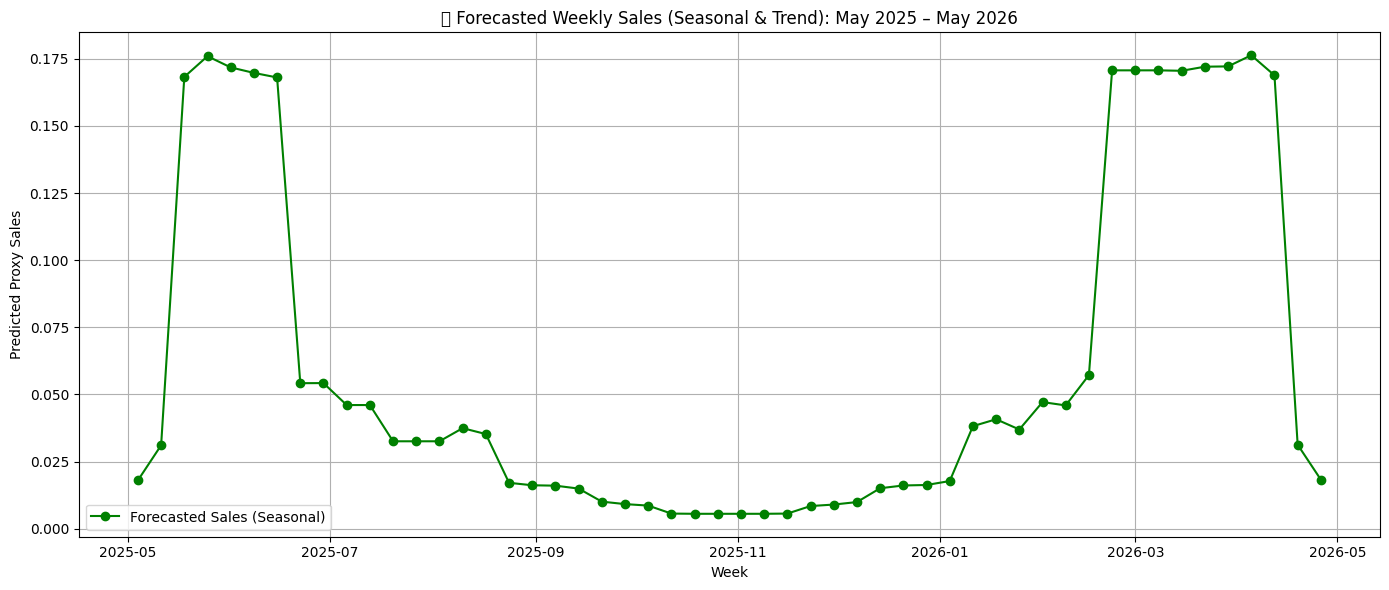

In [ ]:
# STEP B: Forecasting Future Weekly Sales (May 2025 – May 2026) with SEASONALITY & TREND

# 1. Same weekly date range
future_weeks = pd.date_range(start='2025-05-01', end='2026-05-01', freq='W')
weeks = len(future_weeks)

# 2. Use same historical averages
avg_price = merged_df['Price'].mean()
avg_sentiment = merged_df['avg_sentiment'].mean()
avg_rating = merged_df['avg_rating'].mean()
avg_reviews = merged_df['review_count'].mean()
avg_bsr = merged_df['Best Seller Rank'].mean()

# 3. Simulate seasonal patterns + trend
trend = np.linspace(-1, 1, weeks)  # Optional: overall upward or downward trend

df_future_seasonal = pd.DataFrame({
    'Date': future_weeks,
    'Price': avg_price + 0.5 * np.sin(np.linspace(0, 1.5 * np.pi, weeks)),
    'review_count': avg_reviews + 5 * np.cos(np.linspace(0, 2 * np.pi, weeks)) + trend,
    'avg_rating': avg_rating + 0.05 * np.sin(np.linspace(0, 1.5 * np.pi, weeks)),
    'avg_sentiment': avg_sentiment + 0.1 * np.sin(np.linspace(0, 3 * np.pi, weeks)),
    'Best Seller Rank': avg_bsr + 150 * np.cos(np.linspace(0, 2.5 * np.pi, weeks)) + trend * 50
})

# 4. Predict
X_seasonal = df_future_seasonal[['Price', 'review_count', 'avg_rating', 'avg_sentiment', 'Best Seller Rank']]
# Rename the 'Date' column to 'ds' for Prophet compatibility
X_seasonal = X_seasonal.rename(columns={'Date': 'ds'})  # Rename column if necessary
#The model was trained with Random Forest previously but was overwritten to Prophet so we revert back to the Random Forest model (model_xgb)
df_future_seasonal['PredictedSales'] = model_xgb.predict(X_seasonal[['Price', 'review_count', 'avg_rating', 'avg_sentiment', 'Best Seller Rank']]) # Use model_xgb

# 5. Plot
plt.figure(figsize=(14,6))
plt.plot(df_future_seasonal['Date'], df_future_seasonal['PredictedSales'], marker='o', color='green', label='Forecasted Sales (Seasonal)')
plt.title('📦 Forecasted Weekly Sales (Seasonal & Trend): May 2025 – May 2026')
plt.xlabel('Week')
plt.ylabel('Predicted Proxy Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()